<a href="https://colab.research.google.com/github/Alveuz/EquivalentImputation/blob/master/notebooks/EquivImpGFD_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Equivalent Imputation Models for Handling Missing Data in Compositional Geochemical Databases of Geothermal Fluids.

Author: G. Santamaría-Bonfil

---
# Table of contents
1. [Introduction](#Intro)
2. [All Data Compiled](#DataAllComp)
3. [Exploratory Data Analysis ](#DataWrang)
    1. [Raw vs Log Scale](#RawLog)
    2. [Correlation between Variables](#CorrViz)
    3. [Missign Data Mechanisms](#Missigno)
4. [Data Preprocessing](#DataPP)
5. [Imputation of Missing Values](#Imputtn)
    1. [Statistics](#ImpStats)
    2. [KNN Imputer](#ImpKNN)
    3. [Stochastic Regression](#ImpSR)
    4. [Single ML imputation w/No Parameter Tuning](#SIMLnpt)
    5. [Single ML imputation w/Parameter Tuning](#SIMLpt)
    6. [MICE](#MICE)
    7. [Multiple ML imputation w/Parameter Tuning](#MIMLpt)
6. [Imputation Evaluation](#impEval)


---
## 1. Introduction <a name="Intro"></a>


This exercise corresponds to a paper where we are analyzing fluid compositional data (steam/water chemical components concentrations) from different geothermal boreholes/wells. The purpose is to impute missing data in the whole dataset so it can be used to multiple purposes such as predicting the bottom-hole temperature of a geothermal resource.

<!-- <img src="https://docs.google.com/uc?export=download&id=0B8dKNW_H_KwfVHBMcXk3VGxSSTQ" width="600" align="middle"> -->

Inference is done by employing a compilation of data from different borehole types. However, $(\approx 80\%)$ of the data set has 1 or more features missing simultaneously. If we only use complete feature data points, valuable information between chemical composition and/or the borehole temperature will be lost. Thus, our  endeavour is the imputation of missing data. 

Missing values can be filled by simple approaches such as the mean or median of the feature it belongs. Nonetheless, such proxies underestimate variance, modify relations between variables, and induces an undesired bias into the model. 

Another method for imputation which is more robust is stochastic regression. Any regression model can performe a stochastic regression as long as the predicted value is added a random residual. Imputation by means of Stochastic regression has several advantages over the mean/median proxy like preserving correlation between variables. In this venue, more advanced algorithms can be employed such as single or multiple imputation Machine Learning algorithms.

**Our ultimate goal is that, by imputation missing data we can provide a complete dataset that can be used to improve tasks such as bottom hole temperature forecasting.**

The proposed methodology is as follows:

<img src="https://docs.google.com/uc?export=download&id=1eAdsqZhujOTq4qHcPnOagEU8PNNPLubp" width="1200" align="middle">

First, we will show data and load it into the notebook. Then, an Exploratory Data Analysis (EDA) is carried out, it is composed of a comparison of raw vs log transformed features, the correlation between log transformed variables, and, data missigness mechanisms analysis. Afterwards, data preprocessing is carried out (log transformation -> scaling features [0,1]). After, single and multiple imputation algorithms are carried out. In the case of multiple imputation ML algorithms, data is splitted into training/validation/test data sets for performing training & validation of the model, and making the estimations, respectively.

It is worth to mention that the whole procedure is carried out in several notebooks, whereas the statistical equivalence is done in a R script.
Links to all of these are provided.

---
### 2. All Data Compiled <a name="DataAllComp"></a>

<img src="https://docs.google.com/uc?export=download&id=1e68Zkkqso9X_h2fH6qmcGp7PI_EqjNzG" width="1600" align="middle">


In [ ]:
### UTILS IMPUTATION

def get_missing_df(frame):
  return(frame.isna())

def get_missing_cols(frame):
  return(frame.isna().any())

In [ ]:
!pip install rpy2

### Display compiled data in a table.

In [ ]:
import numpy as np
import pandas as pd

from google.colab import data_table

url = 'https://raw.githubusercontent.com/Alveuz/RandomDataSets/master/Geothermal/Fluid%20Composition/simplifiedWCGDb.csv'
gfd_df = pd.read_csv(url)

data_table.DataTable(gfd_df, include_index=True, num_rows_per_page=10)

In [ ]:
gfd_df.median()

Unnamed: 0      353.500000
Li                6.400000
Na             1416.000000
K               196.500000
Mg                0.180001
Ca               17.000000
Cl             1714.000000
SO4              51.800000
HCO3             88.500001
Temperature     230.000000
dtype: float64

---
## 3. Exploratory Data Analysis <a name="DataWrang"></a>

- Fixing limit detection using a constant i.e. $1\times 10^-6$

In [ ]:
gfd_df_ixes = gfd_df.idUnified.copy()
gfd_df = gfd_df.iloc[:,1:10]

featNames = ["Li", "Na", "K", "Mg", "Ca", "Cl", "SO4", "HCO3"]
yName     = "Temperature"

cation_list = ['Li', 'Ca', 'Mg', 'K', 'Na']
anion_list = ['Cl', 'SO4', 'HCO3'] #CO3,NO3

gfd_df.columns = np.append(featNames,yName)
gfd_df[['Mg','HCO3']] = gfd_df[['Mg','HCO3']]+0.000001

data_table.DataTable(gfd_df, include_index=True, num_rows_per_page=10)

In [ ]:
gfd_all_df = gfd_df.copy()

data_table.DataTable(gfd_all_df, include_index=True, num_rows_per_page=10)

### 3.1. Raw vs Log Scale <a name="RawLog"></a>

#### 3.1.1. Raw Data

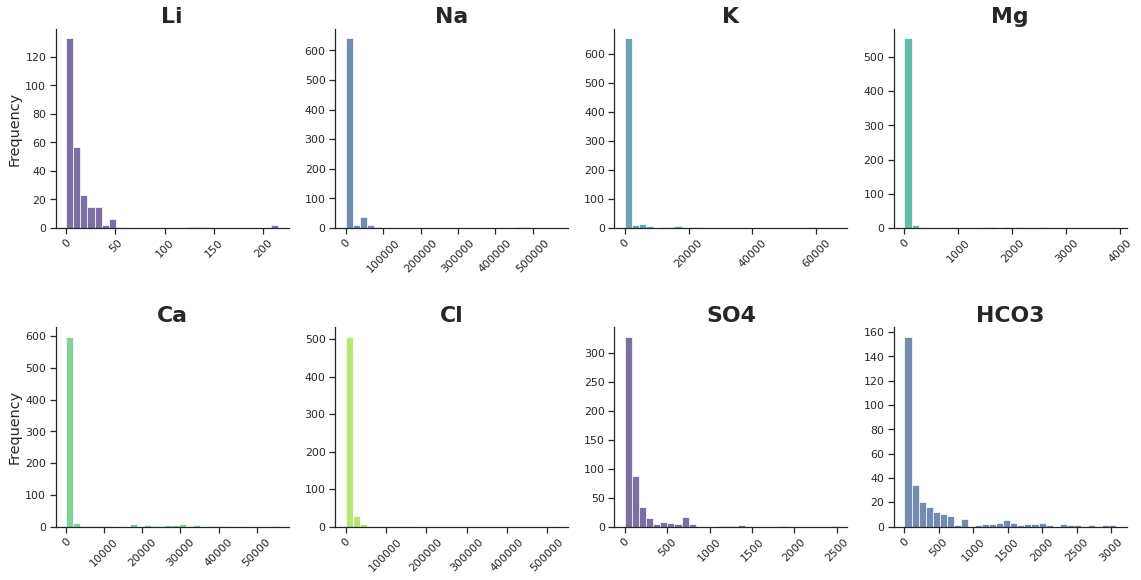

In [ ]:
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
sns.set(style="ticks");


def facet_hist(x, y, c, **kwargs):
    """Draw scatterplot with point colors from a faceted DataFrame columns."""
    # kwargs.pop("color")
    plt.hist(x,bins=30, **kwargs)

gfd_mlt = pd.melt(gfd_all_df, id_vars=['Temperature'])
# gfd_mlt = gfd_mlt.drop(columns='Temperature')

cmap = plt.cm.viridis

g = sns.FacetGrid(gfd_mlt, col="variable", col_wrap = 4, 
                  palette = sns.color_palette("viridis"),
                  hue = 'variable', 
                  sharex=False, sharey=False, height=4, aspect=1)

g.map(facet_hist, "value", "Temperature", "Temperature", alpha=0.7)
g.set_titles(col_template="{col_name}", fontweight='bold', size=22)
# g.set_xticklabels(rotation = 45)
g.fig.subplots_adjust(hspace=.5)

#have access to figures axes array
gg = g.axes.flat

gg[0].set_ylabel('Frequency', fontsize='large')
gg[4].set_ylabel('Frequency', fontsize='large')

for ax in gg:
  ax.set_xlabel('')
  for label in ax.get_xticklabels():
    label.set_rotation(45)

#### 3.1.2. Log Scale Data.

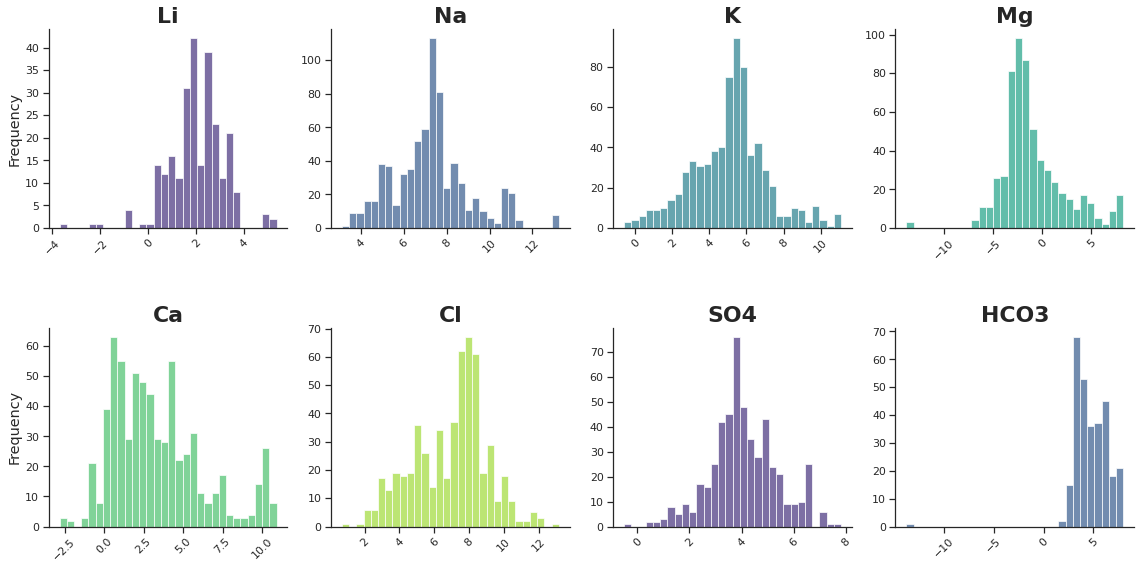

In [ ]:
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
sns.set(style="ticks");


def facet_hist(x, y, c, **kwargs):
    """Draw scatterplot with point colors from a faceted DataFrame columns."""
    # kwargs.pop("color")
    plt.hist(x,bins=30, **kwargs)

gdf_log = gfd_all_df.copy()
gdf_log[featNames] = np.log(gdf_log[featNames])

gfd_mlt = pd.melt(gdf_log, id_vars=['Temperature'])

cmap = plt.cm.viridis

g = sns.FacetGrid(gfd_mlt, col="variable", col_wrap = 4, 
                  palette = sns.color_palette("viridis"),
                  hue = 'variable', 
                  sharex=False, sharey=False, height=4, aspect=1)

g.map(facet_hist, "value", "Temperature", "Temperature", alpha=0.7)
g.set_titles(col_template="{col_name}", fontweight='bold', size=22)
# g.set_xticklabels(rotation = 45)
g.fig.subplots_adjust(hspace=.5)

#have access to figures axes array
gg = g.axes.flat

gg[0].set_ylabel('Frequency', fontsize='large')
gg[4].set_ylabel('Frequency', fontsize='large')

for ax in gg:
  ax.set_xlabel('')
  for label in ax.get_xticklabels():
    label.set_rotation(45)


### 3.2. Correlation between Variables <a name="CorrViz"></a>

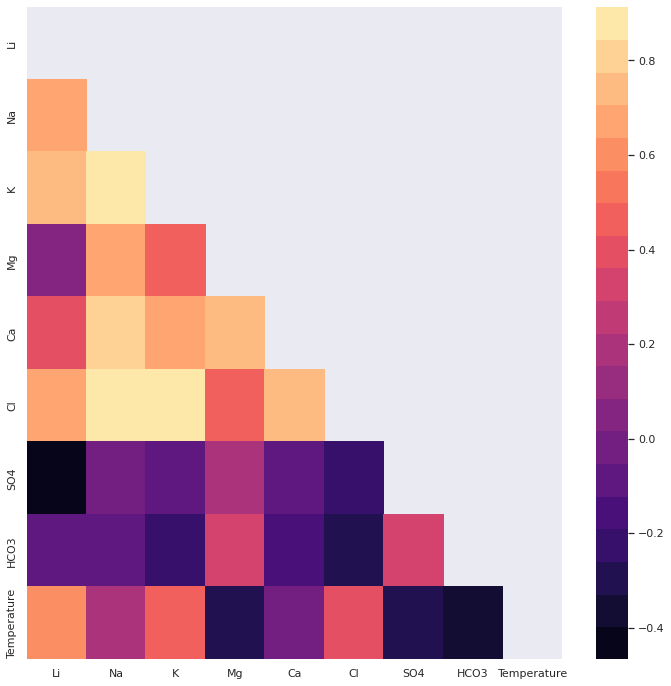

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Compute the correlation matrix
# corr_mtx = gdf_log.corr()
# corr_mtx = gfd_all_df.corr('pearson')
corr_mtx = gdf_log.corr('pearson')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_mtx, dtype=np.bool))

f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr_mtx,
            mask=mask, 
            cmap=sns.color_palette("magma", 20))
# sns.heatmap(corr_mtx,ax=ax, cmap ="YlGnBu", linewidths = 0.1,)

### 3.3. Missing Data Mechanisms Assessment. <a name="Missigno"></a>

In [ ]:
pip install missingno

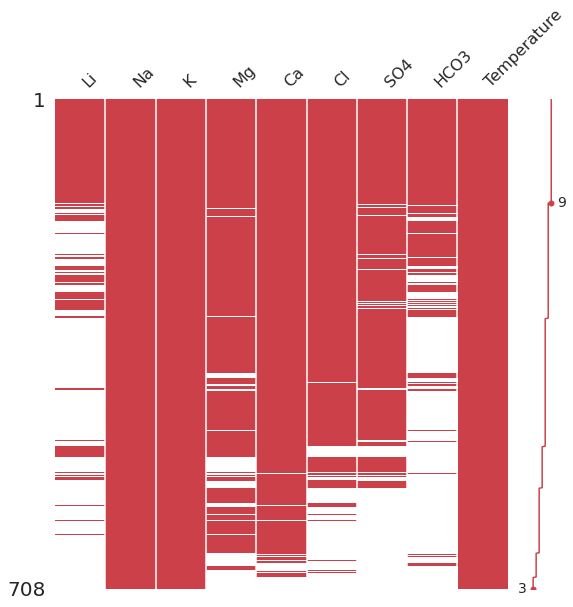

In [ ]:
# Importing the libraries 
import pandas as pd 
import missingno as msno 
import matplotlib.cm as cm
from matplotlib import colors

inferno = cm.get_cmap('inferno', 12)  
c = inferno(0.5)

# Visualize missing values as a matrix 
s1= msno.matrix(gdf_log,figsize=(9,9),
                filter = "bottom", 
                sort= "descending", color = c[0:3])

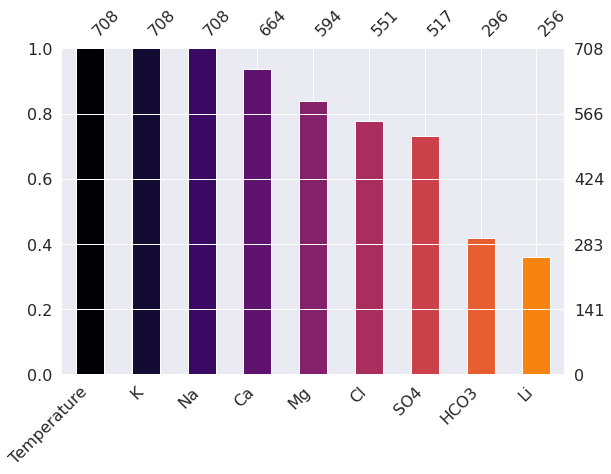

In [ ]:
# Importing the libraries 
import pandas as pd 
import missingno as msno 

inferno = cm.get_cmap('inferno', 12)  
c = inferno(range(12))[:,0:3]

# Visualize the number of missing 
# values as a bar chart 
msno.bar(gdf_log, figsize=(9,6),
         filter='top', sort = 'descending',
         color=c) 

#### Nullity Correlation

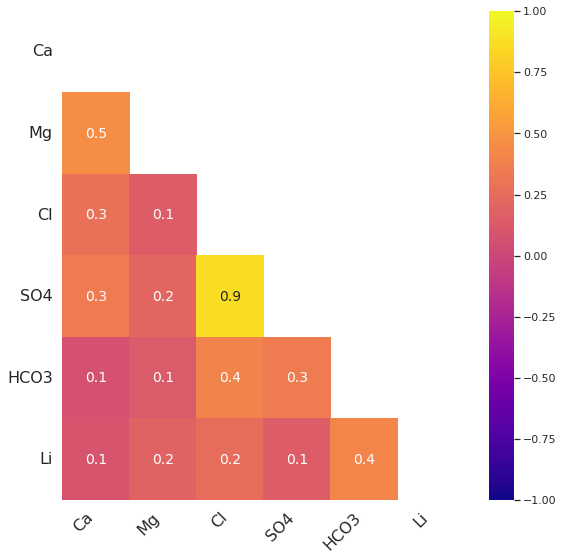

In [ ]:
# Importing the libraries 
import pandas as pd 
import missingno as msno 
# Visualize the number of missing 
# values as a bar chart 
msno.heatmap(gdf_log, figsize=(9,9),
             filter='top', sort = 'descending',
             cmap='plasma') 

#### Nullity Correlation Hierarchical Clustering

6372
[[ 1.          2.          0.          2.        ]
 [ 8.          9.          0.          3.        ]
 [ 5.          6.          6.164414    2.        ]
 [ 4.         10.          6.63324958  4.        ]
 [ 3.         12.         10.32621331  5.        ]
 [11.         13.         13.11018178  7.        ]
 [ 0.          7.         14.14213562  2.        ]
 [14.         15.         19.52447665  9.        ]]


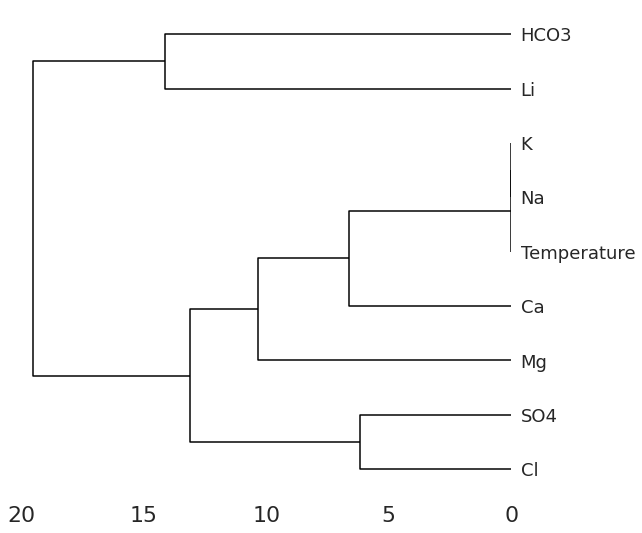

In [ ]:
from scipy.cluster.hierarchy import linkage

df = msno.nullity_filter(gdf_log, filter='top', n=0, p=0)
# Link the hierarchical output matrix, figure out orientation, construct base dendrogram.
x = np.transpose(df.isnull().astype(int).values)
Z = linkage(x, 'average')
print(x.size)
print(Z)

msno.dendrogram(gdf_log, figsize=(9,9),fontsize=18,
                orientation = 'left') 

---
## 4. Data Preprocessing <a name="DataPP"></a>

<img src="https://docs.google.com/uc?export=download&id=1P6QhcCJeJjKpELHVXBqnKroL3LkM9dP_" width="700" align="middle">

In [ ]:
import pickle

from sklearn.preprocessing import MinMaxScaler
featNames = ["Li", "Na", "K", "Mg", "Ca", "Cl", "SO4", "HCO3"]
yName     = "Temperature"
cation_list = ['Li', 'Ca', 'Mg', 'K', 'Na']
anion_list = ['Cl', 'SO4', 'HCO3']

names_dict = {'feat_names':featNames,
              'y_name':yName,
              'cation_list':cation_list,
              'anion_list':anion_list
              }


na_ixes = gfd_all_df.isna()

t_names = featNames

sclr_01 = MinMaxScaler()

#Create the new dataset, namely gdf_norm
#Apply log transformation to Cation/Anion features
#Mg and HCO3 have some measurements with 0 value, a constant 1x10^-6
#is added
gdf_norm = gfd_all_df.copy()
# gdf_norm[['Mg','HCO3']] = gdf_norm[['Mg','HCO3']]+0.000001
gdf_norm[featNames] = np.log(gdf_norm[featNames],)

#Scale all features between 0 and 1
#sklearn.minmaxscaler wont work with missing values
# sclr_01.fit(gdf_log)
#workaround
scaler = {'min':gdf_norm[t_names].min(),
          'max':gdf_norm[t_names].max()}

gdf_norm[t_names]=(gdf_norm[t_names]-scaler.get('min'))/(scaler.get('max')-scaler.get('min'))

data_table.DataTable(gdf_norm, include_index=True, num_rows_per_page=10)

with open('data_vars.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(na_ixes, f)
    pickle.dump(gfd_all_df, f)
    pickle.dump(gdf_norm, f)
    pickle.dump(names_dict,f)

f = open('pp_vars.pkl', 'wb')
pickle.dump(scaler, f)
f.close()

data_table.DataTable(gdf_norm, include_index=True, num_rows_per_page=10)

**Note: Observe that the preprocessed data, and other parameters are stored into the pickle files `data_vars.pkl` and `pp_vars.pkl`, respectively. The data stored into these files will be used by other Python notebooks during the experimentation in section 5.**

---
## 5. Imputation of Missing Values <a name="Imputtn"></a>

- We require [AutoImpute](https://pypi.org/project/autoimpute/) for viz and stochastic regression.

In [ ]:
!pip install autoimpute

     |████████████████████████████████| 100 kB 4.7 MB/s 


### 5.1. Single Value Imputation

#### 5.1.1. With Statistics <a name="ImpStats"></a>

In [ ]:
import pickle

import numpy as np
import pandas as pd
from autoimpute.imputations import SingleImputer
from autoimpute.visuals import plot_imp_scatter
from autoimpute.visuals import plot_md_locations

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

np.random.seed(0)

# # We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = gdf_norm.columns[gdf_norm.isna().any()].tolist()
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')

print(gdf_norm.dtypes)

imp_mean.fit(gdf_norm)
imp_median.fit(gdf_norm)

gdf_norm_mean = imp_mean.transform(gdf_norm)
gdf_norm_median = imp_median.transform(gdf_norm)

gdf_nmean_df = pd.DataFrame(gdf_norm_mean, 
                             columns=gdf_norm.columns)

gdf_nmedian_df = pd.DataFrame(gdf_norm_median, 
                             columns=gdf_norm.columns)

with open('mean_imp_vars.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(imp_mean, f)
    pickle.dump(gdf_nmean_df, f)

with open('median_imp_vars.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(imp_median, f)
    pickle.dump(gdf_nmedian_df, f)

data_table.DataTable(gdf_nmean_df, include_index=True, num_rows_per_page=10)

Li             float64
Na             float64
K              float64
Mg             float64
Ca             float64
Cl             float64
SO4            float64
HCO3           float64
Temperature    float64
dtype: object


In [ ]:
data_table.DataTable(gdf_nmedian_df, include_index=True, num_rows_per_page=10)

#### 5.1.2. KNN Imputer <a name="ImpKNN"></a>

- [Nan_euclidean_distances](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.nan_euclidean_distances.html)

In [ ]:
import pickle

from sklearn.impute import KNNImputer
from sklearn.impute import MissingIndicator

np.random.seed(0)

# # We create the preprocessing pipelines for both numeric and categorical data.
imp_knn = KNNImputer(n_neighbors=2)
# print(MissingIndicator().fit_transform(gdf_norm))
imp_knn.fit(gdf_norm)

gdf_norm_knn = imp_knn.transform(gdf_norm)

gdf_nknn_df = pd.DataFrame(gdf_norm_knn, 
                             columns=gdf_norm.columns)

with open('knn_imp_vars.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(imp_knn, f)
    pickle.dump(gdf_nknn_df, f)

data_table.DataTable(gdf_nknn_df, include_index=True, num_rows_per_page=10)

#### 5.1.3 Stochastic Regression <a name="ImpSR"></a>
- [AutoImpute](https://pypi.org/project/autoimpute/)

In [ ]:
import pickle

from autoimpute.imputations import SingleImputer
from autoimpute.imputations.series import StochasticImputer
from autoimpute.visuals import plot_imp_scatter
from autoimpute.visuals import plot_md_locations

full_pred = ["Na", "K", "Temperature"]

gdf_stc = gdf_norm.copy()

si = SingleImputer(
                strategy="stochastic",
                predictors={"Li": full_pred, "Mg": full_pred, "Ca": full_pred,
                          "Cl": full_pred, "SO4": full_pred, "HCO3": full_pred}, 
                seed = 1
                )


si.fit(gdf_stc)

gdf_norm_si = si.transform(gdf_stc)

with open('stoc_imp_vars.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(si, f)
    pickle.dump(gdf_norm_si, f)

data_table.DataTable(gdf_norm_si, include_index=True, num_rows_per_page=10)

#### 5.1.4. Imputation using ML Regressors 

- Decision Tree Regression
- Support Vector Regression
  - Kernel $\{Linear,\ Radial\}$

##### 5.1.4. Only full variables are employed as predictors
$X=\{Na,\ K,\ Temperature\}$

###### a) No Paramater Tuning <a name="SIMLnpt"></a>

<!--NAVIGATION-->
< [Model 5.1.4.a](https://colab.research.google.com/drive/1YmeJBGpn4yL4n03pUHEdjuNwveGnwkqa#scrollTo=RFQnDz3Qw_-f)>

###### b) Paramater Tuning throug Grid Search (GS) <a name="SIMLpt"></a>

<!--NAVIGATION-->
< [Model 5.1.4.b](https://colab.research.google.com/drive/1xxQWBhOb4-AdCky8SzyGCuKmuDiIWn0A#scrollTo=tBEFrZ7zZdS0)>

### 5.2. Multiple Imputation

##### 5.2.1. MICE: Multiple Imputation by Chained Equations <a name="MICE"></a>


<!--NAVIGATION-->
< [Model 5.2.1](https://colab.research.google.com/drive/1HfOKyFPeGjvR4QnAhgIMNa8Dswh2ZWiW)>



##### 5.2.2. ML Algorithms using all variables as predictors <a name="MIMLpt"></a>

Using multiple ML regressors, each feature with missing values is modeled as a function of other features, and uses the estimated model for imputation. 

It does so in an iterated round-robin fashion: at each step, a feature column is designated as output $y$ and the other feature columns are treated as inputs $X$. A regressor is fit on $(X, y)$ for known $y$. Then, the regressor is used to predict the missing values of $y$. This is done for each feature in an iterative fashion, and then is repeated for ``max_iter=10`` imputation rounds. 

<!--NAVIGATION-->
< [Model 5.2.2](https://colab.research.google.com/drive/1IFhsAhilzz31OysGCuNq5LbiSCetpuzL)>

## 6. Imputation Evaluation <a name="impEval"></a>

Although we can assess accuracy if we conduct a simulation (as we know the true values of y where y is missing), this assessment is misguided. The goal of imputation is to preserve the structure of the data, not correctly guess the true value of the missing points. With real-world data, we often do not have and never will have "true" values. Therefore, accuracy is not the best objective. Instead, we want to preserve the covariance (and thus correlation) between features after imputation takes place. If we preserve the data's structure, we can more safely assume that our imputations are plausible. Now, this objective assumes we are working with data that is at least Missing at Random (MAR), as do all the methods utilized in this experimentation. 

For this purpose we analyze results using an Equivalence Hypothesis Testing.

<!--NAVIGATION-->
< [Imputation Assessment](https://colab.research.google.com/drive/1nK2eM-XxYXOLk94ukPeoEXf4BqiJjyvf)>
